In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import wandb

import utils
from dataset import StateActionEffectDataset
import environment

run_id = "3uvh22kl"


/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
pybullet build time: May 20 2022 19:44:17


In [2]:
train_set = StateActionEffectDataset("v4", "test")
val_set = StateActionEffectDataset("v4", "val")

run = wandb.init(entity="colorslab",project="multideepsym", resume="must", id=run_id)
run = wandb.Api().run("colorslab/multideepsym/" + run_id)
model = utils.create_model_from_config(run.config)
model.load("_best", from_wandb=True)

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Currently logged in as: mbatuhancelik (colorslab). Use `wandb login --relogin` to force relogin


wandb: ERROR Failed to sample metric: Not Supported


In [3]:
def single_iteration_data(data):
    for key in ["action", "state", "effect"]:
        data[key] = data[key].unsqueeze(0).expand(-1, 13, -1)
    data["pad_mask"] = data["pad_mask"].unsqueeze(0).expand(-1, 13)
    return data

In [4]:
from tqdm import tqdm
val_loss = {}
predictions = {}
for i in tqdm(range(len(val_set))):
    sample = single_iteration_data(val_set.__getitem__(i))
    with torch.no_grad():
        loss, pred = model.loss_with_pred(sample)
        val_loss[loss.cpu().item()] = i
        predictions[loss.cpu().item()] = pred.cpu()

loss_sorted = list(val_loss.keys())
loss_sorted.sort()
loss_sorted.reverse()

100%|██████████| 20000/20000 [01:50<00:00, 181.43it/s]


In [5]:
loss_sorted[0]

135.95083618164062

In [6]:
loss_sorted[0]

135.95083618164062

In [7]:
def plot_effect_prediction_difference(loss):
    print(loss)
    id = val_loss[loss]
    sample = train_set.__getitem__(id)
    num_objects = torch.count_nonzero(sample["pad_mask"]).item()
    num_objects = 13
    x = np.arange((num_objects))  # the label locations
    width = 0.33  # the width of the bars
    multiplier = 0

    fig, [ax, ax2] = plt.subplots(nrows = 2,constrained_layout=True)
    labels = ["dx","dy" , "dz"]
    for i in range(3):
        offset = width * multiplier
        rects = ax.bar(x + offset,( predictions[loss].cpu() - sample["effect"])[:,:num_objects,i][0].numpy(), width, label=labels[i])
        # ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Length (m)')
    ax.set_title('prediction - effect')
    ax.set_xticks(x + width, "")
    ax.legend(ncols=3)

    labels = ["rot_x","rot_y" , "rot_z"]
    for i in range(3):
        offset = width * multiplier
        rects = ax2.bar(x + offset,( predictions[loss].cpu() - sample["effect"])[:,:num_objects,i+ 3][0].numpy(), width, label=labels[i])
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax2.set_ylabel('in radians')
    # ax2.set_title('Objects')
    ax2.set_xticks(x + width, "")
    ax2.legend(ncols=3)
    # ax.set_ylim(0, 10)

    plt.show()

def plot_prediction_effect_ds(loss):
    print(loss)
    id = val_loss[loss]
    sample = train_set.__getitem__(id)
    num_objects = 13
    x = np.arange((num_objects))  # the label locations
    width = 0.33  # the width of the bars
    multiplier = 0

    fig, [ax, ax2] = plt.subplots(nrows = 2,constrained_layout=True)
    labels = ["dx","dy" , "dz"]
    for i in range(3):
        offset = width * multiplier
        rects = ax.bar(x + offset,( predictions[loss].cpu())[:,:num_objects,i][0].numpy(), width, label=labels[i])
        # ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Length (m)')
    ax.set_title('prediction')
    ax.set_xticks(x + width, "")
    ax.legend(ncols=3)

    labels = ["dx","dy" , "dz"]
    for i in range(3):
        offset = width * multiplier
        rects = ax2.bar(x + offset,( sample["effect"])[:num_objects,i].numpy(), width, label=labels[i])
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax2.set_ylabel('Length (m)')
    ax2.set_title('effect')
    ax2.set_xticks(x + width, "")
    ax2.legend(ncols=3)

def compare_vectors(loss):
    fig = plt.figure(figsize=( 17, 39))
    xy , yz , xz = [], [], []

    
    sample = val_set.__getitem__(val_loss[loss])
    pred = predictions[loss][0]

    state = sample["state"]
    effect = sample["effect"]
    x, y, z =state[:, 0].numpy() ,state[:, 1].numpy() ,state[:, 2].numpy() 
    u,v,w, u2, v2,w2 = effect[:,0].numpy() ,effect[:,1].numpy() ,effect[:,2].numpy() ,pred[:,0].numpy() ,pred[:,1].numpy() ,pred[:,2].numpy() 

    for i in range(13):
        xy.append(fig.add_subplot( 13,3,i*3 + 1 , xlabel="x", ylabel="y" ))
        yz.append(fig.add_subplot( 13,3,i*3 + 2 , xlabel="y", ylabel="z" ))
        xz.append(fig.add_subplot( 13,3,i*3 + 3  , xlabel="x", ylabel="z"))


    for i in range(13):
        yz[i].plot([y[i],y[i] + v2[i]],[z[i], z[i]+ w2[i]],color ="r", label= "prediction", alpha= 0.7)
        xz[i].plot([x[i],x[i] + u2[i]],[z[i], z[i]+ w2[i]],color ="r", label= "prediction", alpha= 0.7)
        xy[i].plot([x[i],x[i] + u2[i]],[y[i], y[i]+ v2[i]],color ="r", label= "prediction", alpha= 0.7)
        xy[i].plot([x[i],x[i] + u[i]],[y[i], y[i]+ v[i]],  color ="b", label= "effect")
        yz[i].plot([y[i],y[i] + v[i]],[z[i], z[i]+ w[i]],  color ="b", label= "effect")
        xz[i].plot([x[i],x[i] + u[i]],[z[i], z[i]+ w[i]],  color ="b", label= "effect")
        if sample["pad_mask"][i] == 0:
            xy[i].set_ylabel("Non existent object")
        else:
            xy[i].set_ylabel(str(i))

    xy[0].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
                          ncols=2, mode="expand", borderaxespad=0.)
    

In [22]:
loss_sorted.reverse()

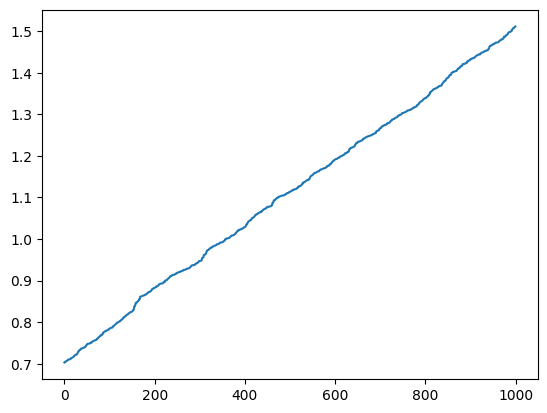

In [23]:
min = 1000
rang = 1000
plt.plot(loss_sorted[min:min+rang])

45.733123779296875


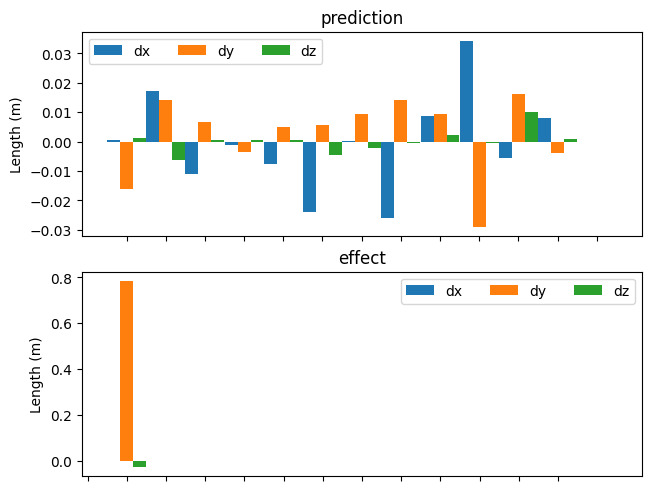

In [9]:
plot_prediction_effect_ds(loss_sorted[1000])

In [10]:
env =  environment.BlocksWorld_v4(gui=1, min_objects=8, max_objects=13)
def replay(id, set):
    
    env.delete_objects()
    state = set.state[id]
    for o in state:
        env.create_object_from_db(o.numpy())
    a= train_set.action[id]
    env.step((a[0].item(), a[1].item()), 
    (a[2].item(),a[3].item()), a[4].item(), a[5].item())
    

{'gui': 1, 'min_objects': 8, 'max_objects': 13}
argv[0]=
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=3
argv[0] = --unused
argv[1] = 
argv[2] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce RTX 2060/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 470.161.03
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 470.161.03
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce RTX 2060/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation


In [11]:
loss_sorted[0]

135.95083618164062

In [27]:
replay(val_loss[loss_sorted[1000]], val_set)

In [28]:
val_set.__getitem__(val_loss[loss_sorted[1000]])[""]

{'state': tensor([[ 7.2509e-01,  2.8775e-01,  4.2499e-01,  1.0731e-04, -1.9777e-06,
          -3.1381e+00,  5.0000e+00],
         [ 8.3760e-01,  6.2791e-02,  4.2499e-01,  1.0730e-04, -1.9775e-06,
          -3.1375e+00,  5.0000e+00],
         [ 9.5012e-01, -3.8715e-01,  4.2499e-01,  1.6902e-04, -3.1213e-06,
          -3.1367e+00,  5.0000e+00],
         [ 1.0625e+00, -1.6212e-01,  4.2499e-01,  1.0733e-04, -1.9780e-06,
          -3.1390e+00,  5.0000e+00],
         [ 7.2584e-01, -4.9824e-01,  4.7497e-01,  9.4683e-05,  1.2167e-04,
          -3.1402e+00,  5.0000e+00],
         [ 1.2928e+00, -3.8779e-01,  4.2499e-01,  1.6355e-07, -8.7504e-05,
           5.6532e-03,  4.0000e+00],
         [ 5.0006e-01, -3.8742e-01,  4.2499e-01,  1.6652e-07, -8.7482e-05,
          -5.6899e-04,  4.0000e+00],
         [ 7.2500e-01,  1.7530e-01,  4.2499e-01,  7.3809e-06, -6.9645e-05,
          -2.9103e-03,  3.0000e+00],
         [ 7.2500e-01, -3.8718e-01,  4.2499e-01,  7.3813e-06, -6.9646e-05,
          -3.0897e-0

In [14]:
sample["state"][:,0]

tensor([[ 1.2825e+00, -1.6108e-01,  4.2499e-01,  1.6881e-04, -3.1176e-06,
         -3.1269e+00,  5.0000e+00]])

In [15]:
pred[:, 1]

tensor([[ 0.0450,  0.0206,  0.0261, -0.9671,  0.0144,  1.1581]],
       device='cuda:0')

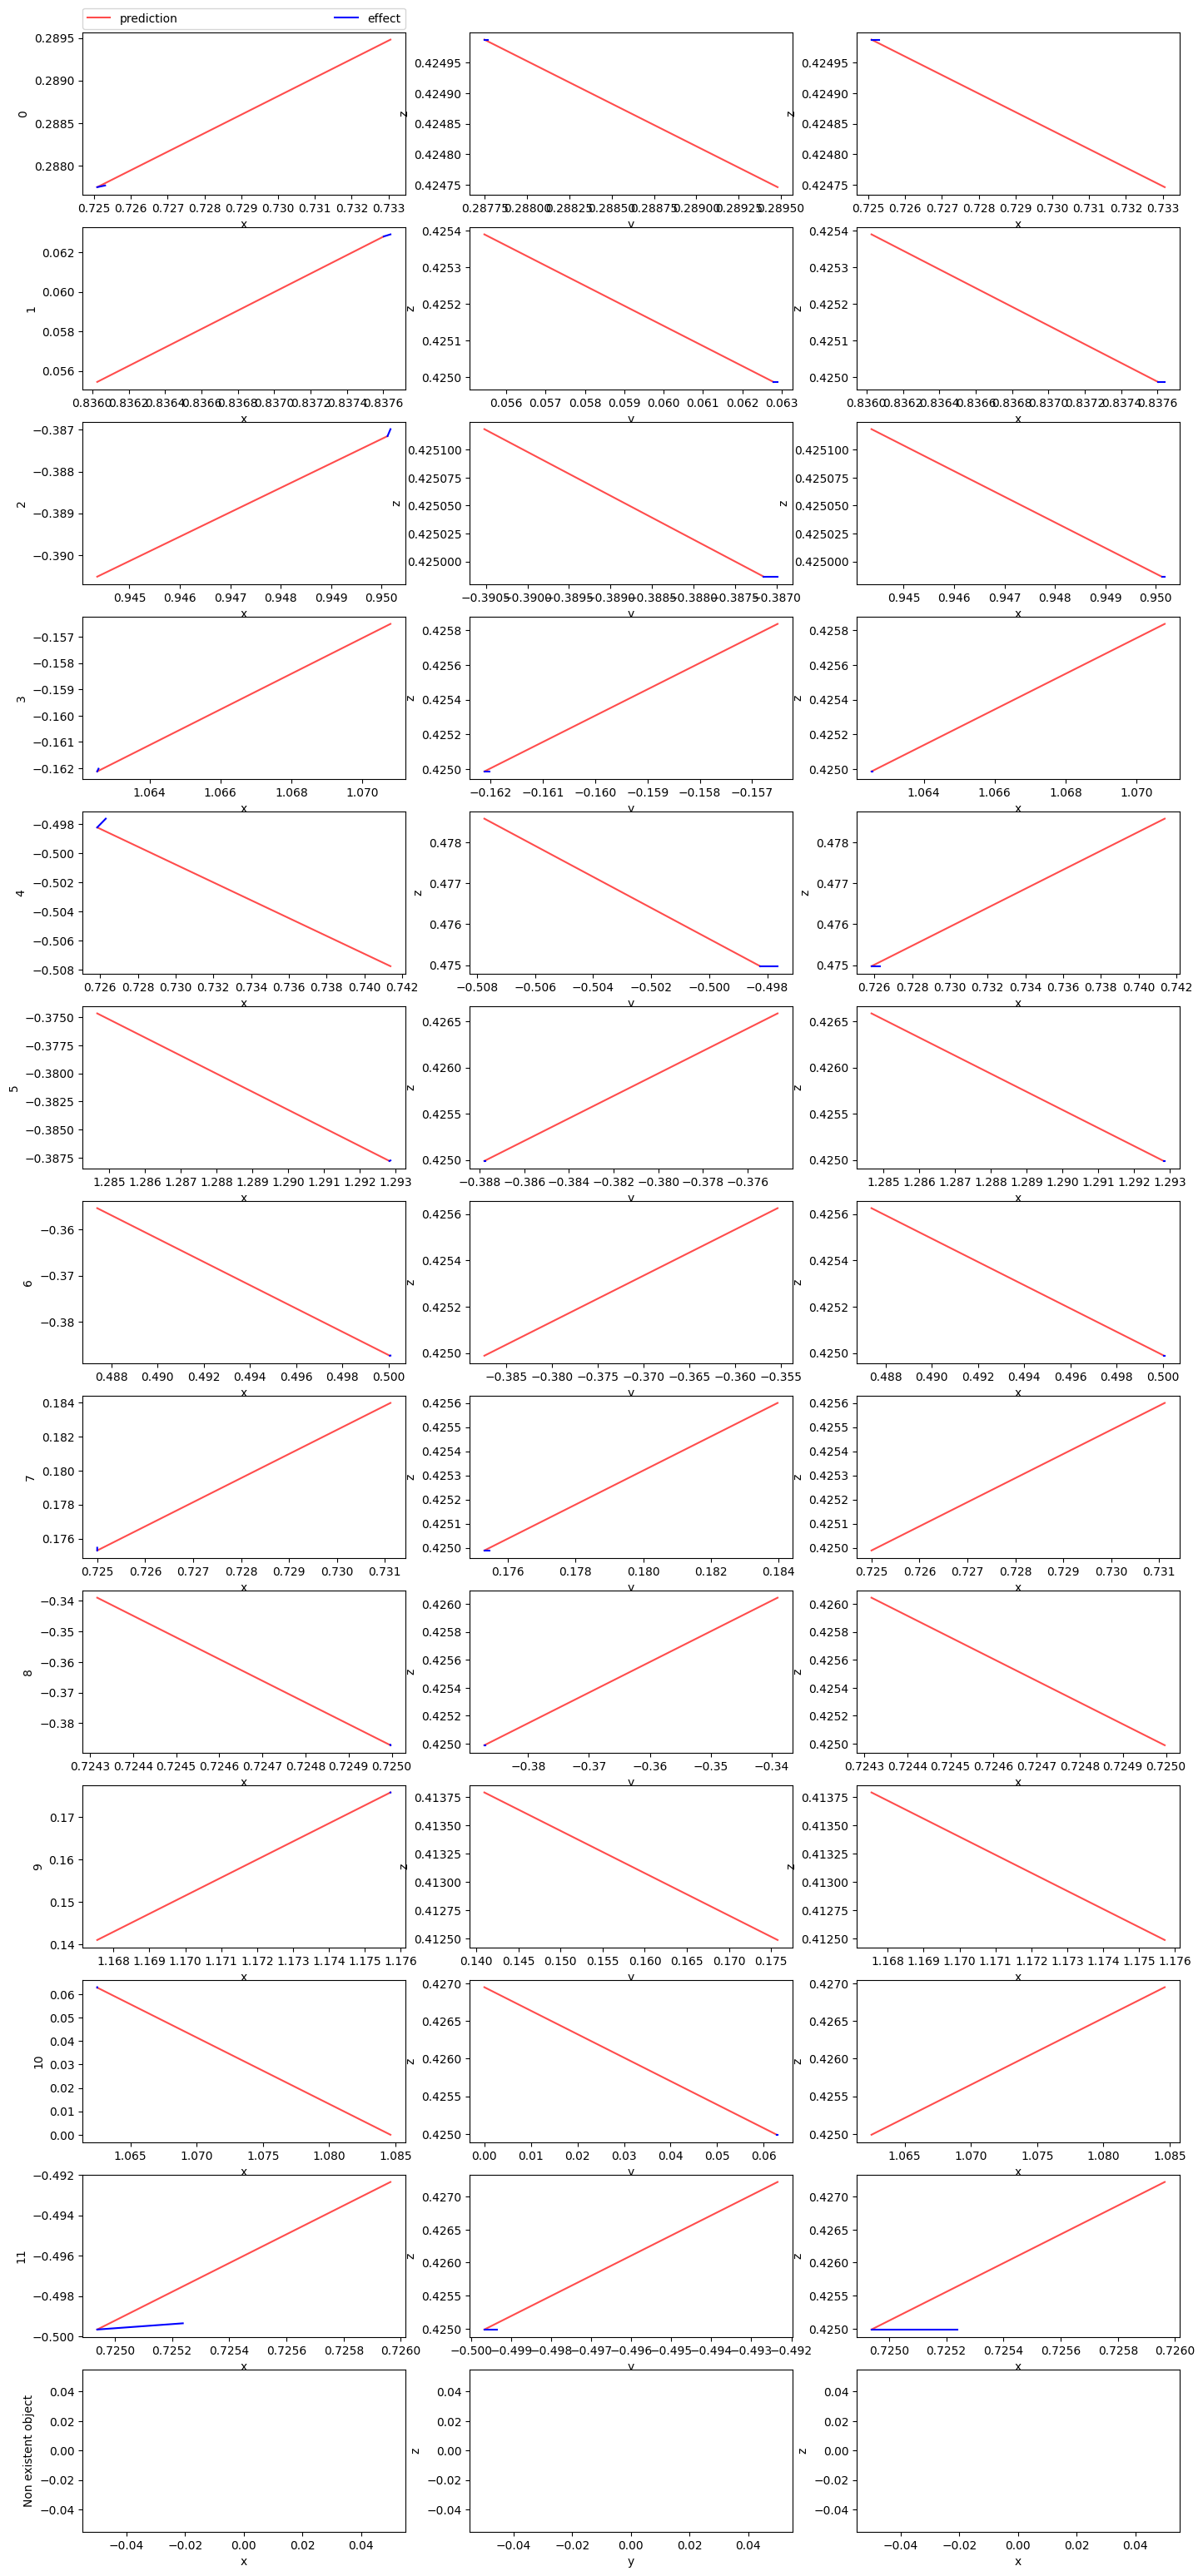

In [24]:
compare_vectors(loss_sorted[1000])

Text(0.5, 1.0, 'Effect')

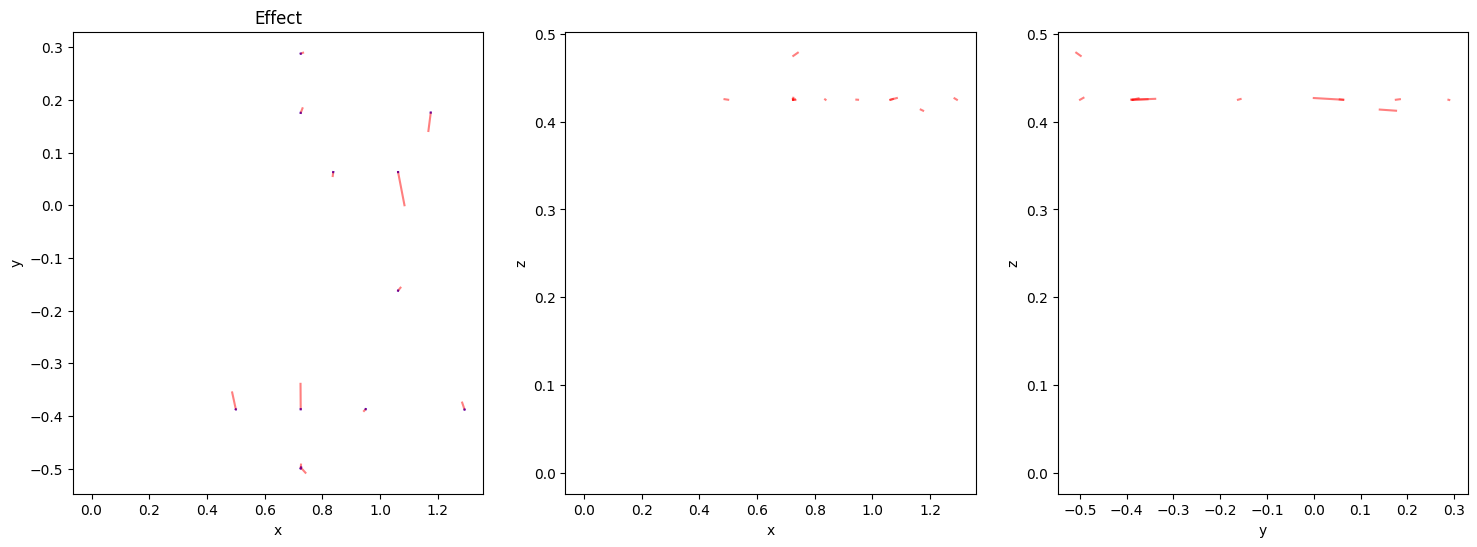

In [29]:

fig = plt.figure(figsize=(18, 6))
# ax = fig.add_subplot( projection='3d')
xy_actual = fig.add_subplot( 1,3,1 , xlabel="x", ylabel="y",)
xz_actual = fig.add_subplot( 1,3,2 , xlabel="x", ylabel="z",)
yz_actual = fig.add_subplot( 1,3,3 , xlabel="y", ylabel="z",)
# xy_pred = fig.add_subplot( 1 3,1,2 , xlabel="x", ylabel="y",)
# xz_pred = fig.add_subplot( 1 3,1,4 , xlabel="x", ylabel="z",)
# yz_pred = fig.add_subplot(   3,1,6 , xlabel="y", ylabel="z",)

# xy_actual = fig.add_subplot( 3,2,1 , xlabel="x", ylabel="y" )
# xy_pred = fig.add_subplot( 3,2,2 , xlabel="x", ylabel="y"  )
# xz_actual = fig.add_subplot( 3,2,3 , xlabel="x", ylabel="z" )
# xz_pred = fig.add_subplot( 3,2,4 , xlabel="x", ylabel="z"  )
# yz_actual = fig.add_subplot( 3,2,5 , xlabel="y", ylabel="z" )
# yz_pred = fig.add_subplot( 3,2,6 , xlabel="y", ylabel="z"  )
# xz = fig.add_subplot(2,2,2 , xlabel="x", ylabel="z")
# yz = fig.add_subplot(2,2,3 , xlabel="y", ylabel="z")

loss = loss_sorted[1000]
sample = val_set.__getitem__(val_loss[loss])
pred = predictions[loss][0]

state = sample["state"]
effect = sample["effect"]
x, y, z =state[:, 0] ,state[:, 1],state[:, 2]
u,v,w, u2, v2,w2 = effect[:,0],effect[:,1],effect[:,2],pred[:,0],pred[:,1],pred[:,2]

# x, y, z =[0, 1 , 4] ,[1 , 4 , 5],[ 3.4, 2.1, 1.9]
# u,v,w, u2, v2,w2 = [1, 0 , 3],[1, 4 , 3],[0,2,4],pred[:,0][:3],pred[:,1][:3],pred[:,2][:3]

for i in range(13):
    xy_actual.plot([x[i],x[i] + u[i]],[y[i], y[i] + v[i]],color ="b")
    xy_actual.plot([x[i],x[i] +  u2[i]],[y[i], y[i] + v2[i]],color ="r", alpha = 0.5)
    yz_actual.plot([y[i],y[i] +  v[i]],[z[i], z[i] + w[i]],color ="b")
    yz_actual.plot([y[i],y[i] +  v2[i]],[z[i], z[i] + w2[i]],color ="r", alpha = 0.5)
    xz_actual.plot([x[i],x[i] +  u[i]],[z[i], z[i] + w[i]],color ="b")
    xz_actual.plot([x[i],x[i] + u2[i]],[z[i], z[i] + w2[i]],color ="r", alpha = 0.5)
    # xy_pred.quiver(x, y,u2 ,v2,color ="r",scale = 1, scale_units= "xy")
# xz_actual.quiver(x, z,u ,w,color ="b",scale = 1, scale_units= "xy")
# xz_pred.quiver(x, z,u2 ,w2,color ="r",scale = 1, scale_units= "xy")
# yz_actual.quiver(y, z,v ,w,color ="b",scale = 1, scale_units= "xy")
# yz_pred.quiver(y, z,v2 ,w2,color ="r",scale = 1, scale_units= "xy")

xy_actual.set_title("Effect")
# xy_pred.set_title("Predictions")



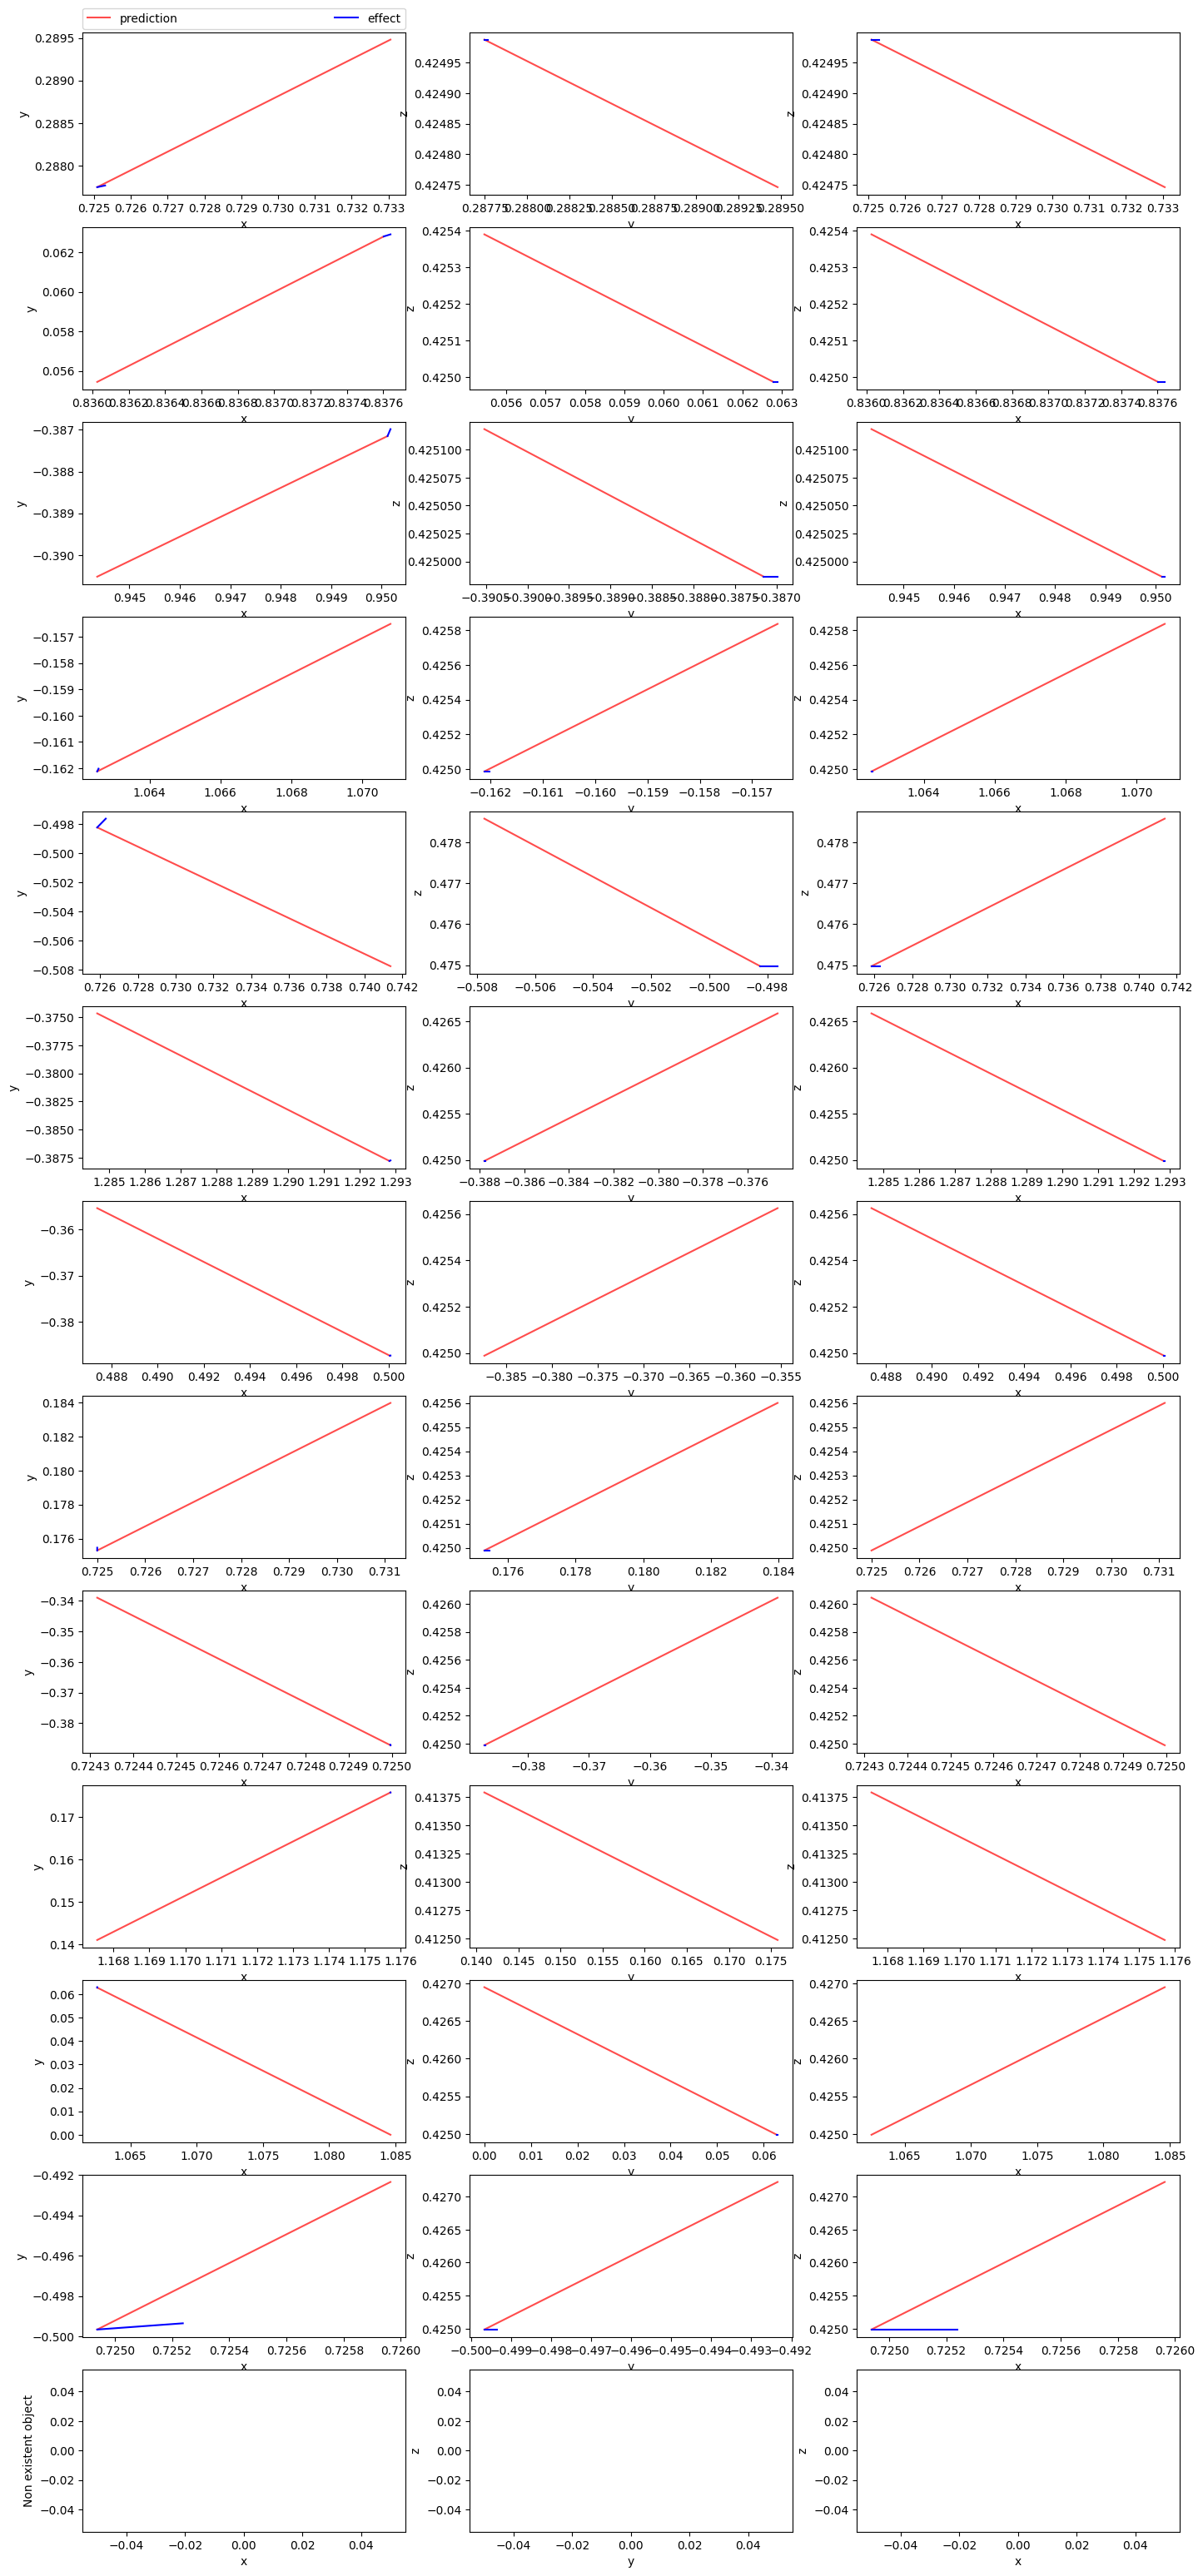

In [26]:

fig = plt.figure(figsize=( 17, 39))
xy , yz , xz = [], [], []

loss = loss_sorted[1000]
sample = val_set.__getitem__(val_loss[loss])
pred = predictions[loss][0]

state = sample["state"]
effect = sample["effect"]
x, y, z =state[:, 0].numpy() ,state[:, 1].numpy() ,state[:, 2].numpy() 
u,v,w, u2, v2,w2 = effect[:,0].numpy() ,effect[:,1].numpy() ,effect[:,2].numpy() ,pred[:,0].numpy() ,pred[:,1].numpy() ,pred[:,2].numpy() 

for i in range(13):
    xy.append(fig.add_subplot( 13,3,i*3 + 1 , xlabel="x", ylabel="y" ))
    yz.append(fig.add_subplot( 13,3,i*3 + 2 , xlabel="y", ylabel="z" ))
    xz.append(fig.add_subplot( 13,3,i*3 + 3  , xlabel="x", ylabel="z"))


for i in range(13):
    yz[i].plot([y[i],y[i] + v2[i]],[z[i], z[i]+ w2[i]],color ="r", label= "prediction", alpha= 0.7)
    xz[i].plot([x[i],x[i] + u2[i]],[z[i], z[i]+ w2[i]],color ="r", label= "prediction", alpha= 0.7)
    xy[i].plot([x[i],x[i] + u2[i]],[y[i], y[i]+ v2[i]],color ="r", label= "prediction", alpha= 0.7)
    xy[i].plot([x[i],x[i] + u[i]],[y[i], y[i]+ v[i]],  color ="b", label= "effect")
    yz[i].plot([y[i],y[i] + v[i]],[z[i], z[i]+ w[i]],  color ="b", label= "effect")
    xz[i].plot([x[i],x[i] + u[i]],[z[i], z[i]+ w[i]],  color ="b", label= "effect")
    if sample["pad_mask"][i] == 0:
        xy[i].set_ylabel("Non existent object")

xy[0].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
                      ncols=2, mode="expand", borderaxespad=0.)
